# SWOT L4 Global Mosaic - June 1, 2024

Gridded sea surface height product from AVISO.

**Product**: Experimental Multimission Gridded L4 SSH with SWOT  
**Method**: MIOST (Multiscale Interpolation of Ocean Surface Topography)  
**Version**: v2.0.1  
**Resolution**: 0.125° (~14 km)  
**Coverage**: Global (89.94°S to 89.94°N)  
**Satellites**: SWOT + 7 nadir altimeters  
**DOI**: 10.24400/527896/a01-2025.001

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

## Load Dataset

In [2]:
data_file = 'swot_l4_data/dt_global_allsat_phy_l4_20230924_20250331.nc'
ds = xr.open_dataset(data_file)
print(ds)

<xarray.Dataset> Size: 199MB
Dimensions:           (longitude: 2880, latitude: 1440, time: 1, bounds: 2)
Coordinates:
  * longitude         (longitude) float32 12kB -179.9 -179.8 ... 179.8 179.9
  * latitude          (latitude) float32 6kB -89.94 -89.81 ... 89.81 89.94
  * time              (time) datetime64[ns] 8B 2023-09-24
    longitude_bounds  (longitude, bounds) float64 46kB ...
    latitude_bounds   (latitude, bounds) float64 23kB ...
Dimensions without coordinates: bounds
Data variables:
    sla               (time, latitude, longitude) float64 33MB ...
    ugosa             (time, latitude, longitude) float64 33MB ...
    vgosa             (time, latitude, longitude) float64 33MB ...
    adt               (time, latitude, longitude) float64 33MB ...
    ugos              (time, latitude, longitude) float64 33MB ...
    vgos              (time, latitude, longitude) float64 33MB ...
Attributes: (12/46)
    description:                      Miost analysis 
    Conventions:        

In [3]:
for var in ds.data_vars:
    long_name = ds[var].attrs.get('long_name', 'No description')
    units = ds[var].attrs.get('units', '')
    print(f"{var}: {long_name} ({units})")

sla: Sea level anomaly (m)
ugosa: Geostrophic velocity anomalies: zonal component (m/s)
vgosa: Geostrophic velocity anomalies: meridian component (m/s)
adt: Absolute dynamic topography (m)
ugos: Absolute geostrophic velocity: zonal component (m/s)
vgos: Absolute geostrophic velocity: meridian component (m/s)


In [4]:
import pandas as pd

target_date = pd.Timestamp('2024-06-01')
times = pd.to_datetime(ds.time.values)
time_diffs = np.abs(times - target_date)
closest_idx = time_diffs.argmin()

selected_time = times[closest_idx]
print(f"Target: {target_date}")
print(f"Closest: {selected_time}")
print(f"Difference: {time_diffs[closest_idx]}")

Target: 2024-06-01 00:00:00
Closest: 2023-09-24 00:00:00
Difference: 251 days 00:00:00


## Extract Data

In [5]:
sla = ds['sla'].isel(time=closest_idx)
adt = ds['adt'].isel(time=closest_idx)
ugos = ds['ugos'].isel(time=closest_idx)
vgos = ds['vgos'].isel(time=closest_idx)
time_str = str(ds.time.isel(time=closest_idx).values)[:10]

speed = np.sqrt(ugos**2 + vgos**2)

print(f"Data extracted for: {time_str}")
print(f"SLA range: {float(sla.min().values):.3f} to {float(sla.max().values):.3f} m")
print(f"SLA mean: {float(sla.mean().values):.3f} m")

Data extracted for: 2023-09-24
SLA range: -1.318 to 1.241 m
SLA mean: 0.110 m


## Global View - Sea Level Anomaly

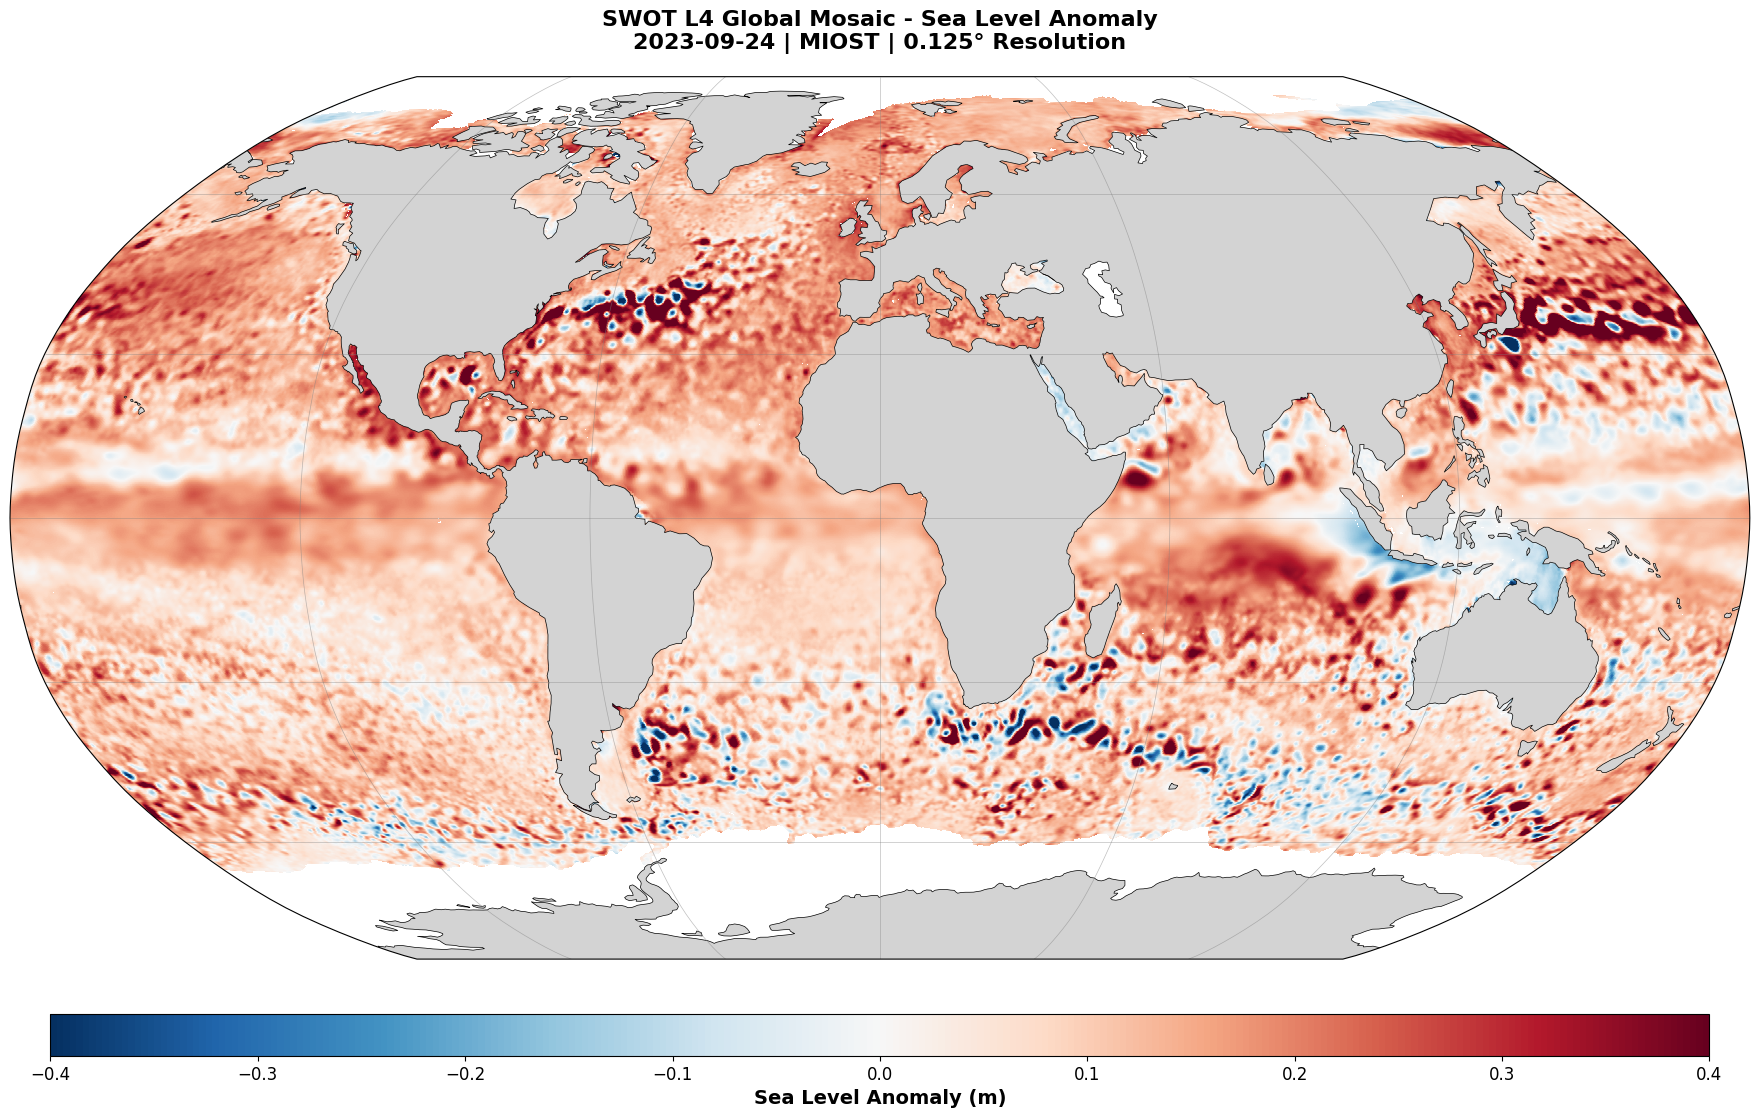

In [6]:
fig = plt.figure(figsize=(24, 12))
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson())

im = sla.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r',
              vmin=-0.4, vmax=0.4, add_colorbar=False, robust=True)

ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black', zorder=2)
ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.5, color='gray')

cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.7, aspect=40)
cbar.set_label('Sea Level Anomaly (m)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

title = f'SWOT L4 Global Mosaic - Sea Level Anomaly\n{time_str} | MIOST | 0.125° Resolution'
ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('swot_l4_global_mosaic_20240601.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## ADT and Geostrophic Visualization

In [ ]:
fig = plt.figure(figsize=(24, 16))

# Global SLA
ax1 = plt.subplot(2, 3, 1, projection=ccrs.Robinson())
sla.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='RdBu_r', 
         vmin=-0.4, vmax=0.4, add_colorbar=True, 
         cbar_kwargs={'label': 'SLA (m)', 'shrink': 0.8})
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.set_title('(a) Sea Level Anomaly', fontsize=14, fontweight='bold')

# Pacific Ocean
ax2 = plt.subplot(2, 3, 2, projection=ccrs.PlateCarree(central_longitude=180))
sla.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='RdBu_r',
         vmin=-0.4, vmax=0.4, add_colorbar=True,
         cbar_kwargs={'label': 'SLA (m)', 'shrink': 0.8})
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.set_extent([120, 240, -60, 60], crs=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
ax2.set_title('(b) Pacific Ocean', fontsize=14, fontweight='bold')

# Atlantic Ocean
ax3 = plt.subplot(2, 3, 3, projection=ccrs.PlateCarree())
sla.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='RdBu_r',
         vmin=-0.4, vmax=0.4, add_colorbar=True,
         cbar_kwargs={'label': 'SLA (m)', 'shrink': 0.8})
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.set_extent([-80, 20, -60, 60], crs=ccrs.PlateCarree())
ax3.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
ax3.set_title('(c) Atlantic Ocean', fontsize=14, fontweight='bold')

# Absolute Dynamic Topography
ax4 = plt.subplot(2, 3, 4, projection=ccrs.Robinson())
adt.plot(ax=ax4, transform=ccrs.PlateCarree(), cmap='viridis',
         add_colorbar=True, robust=True,
         cbar_kwargs={'label': 'ADT (m)', 'shrink': 0.8})
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax4.set_title('(d) Absolute Dynamic Topography', fontsize=14, fontweight='bold')

# Geostrophic Current Speed
ax5 = plt.subplot(2, 3, 5, projection=ccrs.Robinson())
speed.plot(ax=ax5, transform=ccrs.PlateCarree(), cmap='YlOrRd',
          vmin=0, vmax=1.0, add_colorbar=True,
          cbar_kwargs={'label': 'Speed (m/s)', 'shrink': 0.8})
ax5.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax5.set_title('(e) Geostrophic Current Speed', fontsize=14, fontweight='bold')

# Distribution
ax6 = plt.subplot(2, 3, 6)
sla_flat = sla.values.flatten()
sla_flat = sla_flat[~np.isnan(sla_flat)]
ax6.hist(sla_flat, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax6.set_xlabel('Sea Level Anomaly (m)', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.set_title('(f) SLA Distribution', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

stats_text = (f"Mean: {np.mean(sla_flat):.4f} m\n"
              f"Std: {np.std(sla_flat):.4f} m\n"
              f"Min: {np.min(sla_flat):.4f} m\n"
              f"Max: {np.max(sla_flat):.4f} m")
ax6.text(0.97, 0.97, stats_text, transform=ax6.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        fontsize=10, family='monospace')

fig.suptitle(f'SWOT L4 Global Analysis - {time_str}', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('swot_l4_multi_panel_20240601.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

## Regional Focus - Coastal North America

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

regions = [
    {'name': 'Northeast Pacific / Alaska', 'extent': [-180, -120, 40, 65]},
    {'name': 'U.S. West Coast', 'extent': [-135, -115, 30, 50]},
    {'name': 'Gulf of Mexico', 'extent': [-100, -80, 18, 32]},
    {'name': 'U.S. East Coast / Gulf Stream', 'extent': [-80, -60, 30, 45]}
]

for ax, region in zip(axes, regions):
    sla.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r',
             vmin=-0.4, vmax=0.4, add_colorbar=True,
             cbar_kwargs={'label': 'SLA (m)', 'shrink': 0.8, 'orientation': 'horizontal'})
    
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
    
    ax.set_extent(region['extent'], crs=ccrs.PlateCarree())
    ax.set_title(region['name'], fontsize=14, fontweight='bold')

fig.suptitle(f'SWOT L4 Regional Views - {time_str}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('swot_l4_north_america_regions_20240601.png', dpi=200, bbox_inches='tight')
plt.show()

## Extract Regional Subset

In [ ]:
lon_min, lon_max = -180, -120
lat_min, lat_max = 40, 65

regional_ds = ds.sel(
    longitude=slice(lon_min, lon_max),
    latitude=slice(lat_min, lat_max),
    time=ds.time.isel(time=closest_idx)
)

print(f"Region: {lon_min}° to {lon_max}°, {lat_min}° to {lat_max}°")
print(f"Shape: {regional_ds['sla'].shape}")

output_file = 'swot_l4_northeast_pacific_20240601.nc'
regional_ds.to_netcdf(output_file)
print(f"Saved: {output_file}")

In [ ]:
ds.close()

## Summary

Global coverage at 0.125° resolution with multi-mission data fusion. Variables include SLA, ADT, and geostrophic velocities suitable for ocean dynamics analysis.